# Sprint13 TensorFlow

＊TensorFlow バージョン 2.4 推奨
anaconda sub 仮想環境

## 問題1 スクラッチを振り返る

ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。

### 【解答】
・期待する出力に応じて、活性化関数使う必要があった

・ミニバッチ勾配降下法など、効率よく学習するための手法

・重みの初期化にも色々と種類があり、問題に合わせて選択する必要性がある


## 【問題2】スクラッチとTensorFlowの対応を考える

以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。

それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。

【解答】

### ・期待する出力に応じて、活性化関数使う必要があった

    →evaluate関数の中にTensorflowのメソッドで実行されている。（シグモイド関数）

### ・ミニバッチ勾配降下法など、効率よく学習するための手法

    →for epochの中でループ（スクラッチ実装と同じようなイメージ）

### ・重みの初期化にも色々と種類があり、問題に合わせて選択する必要性がある

    →一番シンプルな重みの初期化かな


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
# tensorflow1系
# import tensorflow as tf
# tensorflow2系
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

Using TensorFlow backend.


In [5]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [1]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
# 前処理----------------------------
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
df_2 = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.float32)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 前処理----------------------------

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10#バッチサイズ
num_epochs = 10#エポック数（学習回数）
n_hidden1 = 50#隠れ層ニューロン数
n_hidden2 = 100#隠れ層ニューロン数
n_input = X_train.shape[1]#入力特徴量（列）
n_samples = X_train.shape[0]#入力データ数（行）
n_classes = 1#クラス数

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)



    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
        
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    # 推定結果
    correct_pred = tf.equal(tf.sign(y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy
    
# plot用
loss_list = []
val_loss_list = []
acc_list = []

# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)

    # Plot用
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    acc_list.append(val_acc)

    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
_, test_acc = evaluate(X_test, y_test)

print("test_acc : {:.3f}".format(test_acc))

# print(f'val_loss_list : {val_loss_list}')
# Epoch 0, loss : 4.2078, val_loss : 13.2396, val_acc : 0.375
# Epoch 1, loss : 0.5434, val_loss : 1.7227, val_acc : 0.750
# Epoch 2, loss : 0.2561, val_loss : 2.6336, val_acc : 0.812
# Epoch 3, loss : 0.2531, val_loss : 6.2354, val_acc : 0.500
# Epoch 4, loss : 0.1905, val_loss : 5.7163, val_acc : 0.750
#  loss : 0.4459, val_loss : 6.5535, val_acc : 0.500
# Epoch 6, loss : 0.1342, val_loss : 5.8877, val_acc : 0.750
# Epoch 7, loss : 0.5704, val_loss : 14.0399, val_acc : 0.438
# Epoch 8, loss : 0.4709, val_loss : 7.3149, val_acc : 0.750
# Epoch 9, loss : 0.8030, val_loss : 11.0766, val_acc : 0.500
# test_acc : 0.550
    

Epoch 0, loss : 6.1626, val_loss : 9.1246, val_acc : 0.375
Epoch 1, loss : 0.9170, val_loss : 0.0000, val_acc : 1.000
Epoch 2, loss : 0.6437, val_loss : 0.0000, val_acc : 1.000
Epoch 3, loss : 0.3338, val_loss : 0.8670, val_acc : 0.875
Epoch 4, loss : 0.1765, val_loss : 0.0000, val_acc : 1.000
Epoch 5, loss : 0.1606, val_loss : 0.0026, val_acc : 1.000
Epoch 6, loss : 0.1046, val_loss : 0.0000, val_acc : 1.000
Epoch 7, loss : 0.1593, val_loss : 0.0003, val_acc : 1.000
Epoch 8, loss : 0.1026, val_loss : 0.0000, val_acc : 1.000
Epoch 9, loss : 0.1419, val_loss : 0.0000, val_acc : 1.000
test_acc : 0.900


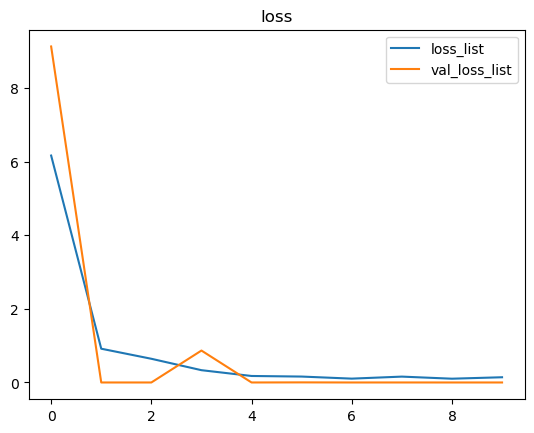

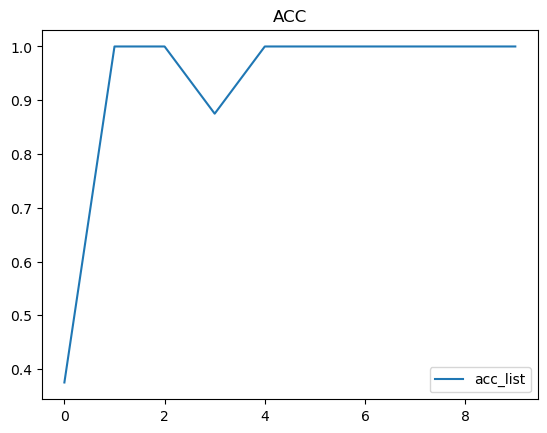

In [2]:
import matplotlib.pyplot as plt
x_label = np.arange(0,10)
acc_x_label = np.linspace(0, 1, 10)


plt.title('loss')
plt.plot(x_label, loss_list, label="loss_list")
plt.plot(x_label, val_loss_list, label="val_loss_list")
plt.legend()
plt.show()

plt.title('ACC')
plt.plot(x_label, acc_list, label="acc_list")
plt.legend()
plt.show()



## 【問題3】3種類すべての目的変数を使用したIrisのモデルを作成

Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類すべてを分類できるモデルを作成してください。


2クラスの分類と3クラス以上の分類の違いを考慮してください。

それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。

《ヒント》

以下の2箇所は2クラス分類特有の処理です。

In [3]:
# 《ヒント》
# 以下の2箇所は2クラス分類特有の処理です。
# loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# ＊tf.signとtf.math.signは同じ働きをします。
# 説明変数と目的変数に分割
# データフレームから条件抽出
# df_2_2 = df_2_2[(df_2_2["Species"] == "Iris-versicolor")|(df_2_2["Species"] == "Iris-virginica")]
# y = df_2_2["Species"]
# X = df_2_2.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# y = np.array(y)
# X = np.array(X).astype(np.float32)
# # ラベルを数値に変換
# y[y=='Iris-versicolor'] = 0
# y[y=='Iris-virginica'] = 1
# y = y.astype(np.float32)[:, np.newaxis]
# # trainとtestに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# # さらにtrainとvalに分割
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# df_2_2 = pd.read_csv(dataset_path)
# y = df_2_2["Species"]
# X = df_2_2.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# y = np.array(y)
# X = np.array(X)
# # y = y.astype(np.int)[:, np.newaxis]

# # 訓練データ/テストデータ/評価データに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# onehotベクトル化
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_train_one_hot = enc.fit_transform(y_train)
# y_val_one_hot = enc.transform(y_val)
# y_test_one_hot = enc.transform(y_test)

y = df_2["Species"]
X = df_2.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y[y=='Iris-setosa'] = 2
y = y.astype(np.float32)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)
# 正規化
X_train /= 255
X_test /= 255
X_val /= 255

In [4]:
# 
# 多値分類（三値）
# 

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3
# 空配列定義
# X = tf.placeholder("float", [None, n_input])
# Y = tf.placeholder("float", [None, n_classes])


# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

class ManyValuedModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)

        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
        
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))#変更
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))#変更
    # 推定結果
    correct_pred = tf.equal(tf.sign(y - 0.5), tf.sign(tf.nn.softmax_cross_entropy_with_logits(logits, y) - 0.5))#変更
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy

loss_list_2 = []
val_loss_list_2 = []
acc_list_2 = []

# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
        
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)
    
    loss_list_2.append(loss)
    val_loss_list_2.append(val_loss)
    acc_list_2.append(val_acc)
    
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
_, test_acc = evaluate(X_test, y_test)

print("test_acc : {:.3f}".format(test_acc))



Epoch 0, loss : 1.1359, val_loss : -2.3404, val_acc : 0.292
Epoch 1, loss : 0.5299, val_loss : -2.9537, val_acc : 0.292
Epoch 2, loss : 0.2319, val_loss : -5.4762, val_acc : 0.292
Epoch 3, loss : 0.1141, val_loss : -5.8080, val_acc : 0.292
Epoch 4, loss : 0.1081, val_loss : -6.0464, val_acc : 0.292
Epoch 5, loss : 0.1117, val_loss : -6.1056, val_acc : 0.292
Epoch 6, loss : 0.1160, val_loss : -6.1831, val_acc : 0.292
Epoch 7, loss : 0.1188, val_loss : -6.2978, val_acc : 0.292
Epoch 8, loss : 0.1193, val_loss : -6.4784, val_acc : 0.292
Epoch 9, loss : 0.1165, val_loss : -6.7699, val_acc : 0.292
test_acc : 0.433


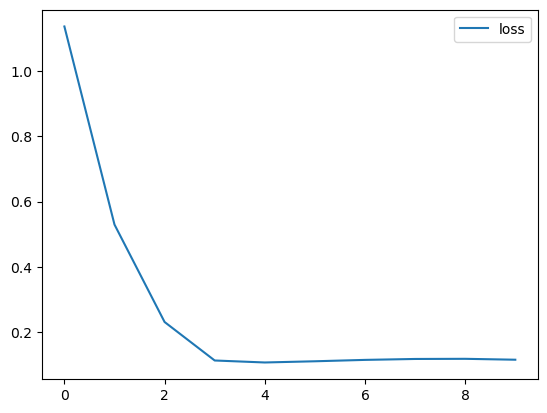

In [6]:
# lossが綺麗に減っている
plt.plot(x_label, loss_list_2,label='loss')
plt.legend()
plt.show()

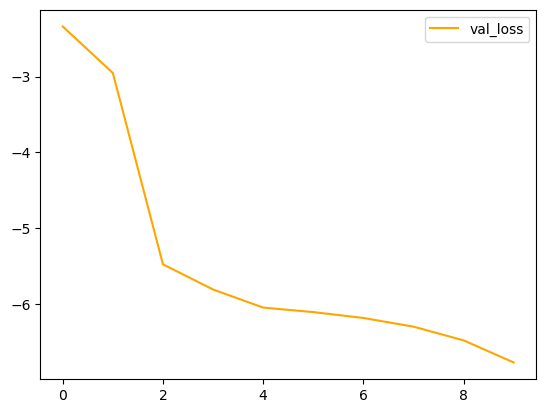

In [7]:
# plt.plot(x_label, loss_list_2)
plt.plot(x_label, val_loss_list_2, color="orange", label='val_loss')
# plt.plot(x_label, loss_list_2)
plt.legend()
plt.show()

## 【問題4】House Pricesのモデルを作成

In [6]:
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

Epoch 0, loss : 3699.4805, val_loss : 3803.4187
Epoch 1, loss : 124.7573, val_loss : 136.6132
Epoch 2, loss : 698.9642, val_loss : 494.6321
Epoch 3, loss : 647.5317, val_loss : 455.0566
Epoch 4, loss : 149.6740, val_loss : 87.4556
Epoch 5, loss : 128.9073, val_loss : 145.9296
Epoch 6, loss : 159.9692, val_loss : 188.5984
Epoch 7, loss : 94.0585, val_loss : 97.2361
Epoch 8, loss : 84.3042, val_loss : 60.3173
Epoch 9, loss : 82.9111, val_loss : 56.4112


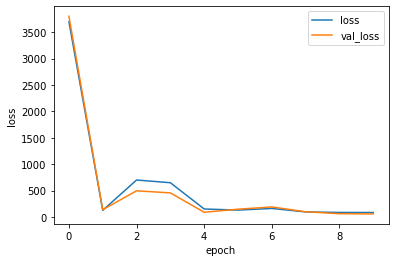

test_mse : 92.556


In [10]:



# 各種変数定義
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 損失記録用リスト
    loss_list = []
    val_loss_list = []
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 損失計算と格納
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        loss_list.append(loss)
        val_loss_list.append(val_loss)    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    
    # 学習過程可視化
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()
    # テストデータに適用
    test_loss = sess.run(loss_op, feed_dict={X: X_test, Y: y_test})
    print("test_mse : {:.3f}".format(test_loss))

## 問題5 MNISTのモデルを作成

In [2]:
from keras.datasets import mnist
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf

# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#　平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 変形
y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [9]:
# 各種変数定義
learning_rate = 0.003
batch_size = 1
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10 # 2値分類からの変更箇所

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train[:1000], y_train[:1000], batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)) # 2値分類からの変更箇所
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1)) # 2値分類からの変更箇所
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, train_loss : 40.0122, val_loss : 39.3950, train_acc : 0.574, val_acc : 0.580
Epoch 1, train_loss : 28.9435, val_loss : 29.1848, train_acc : 0.633, val_acc : 0.631
Epoch 2, train_loss : 24.6745, val_loss : 25.0648, train_acc : 0.668, val_acc : 0.662
Epoch 3, train_loss : 21.2337, val_loss : 21.8312, train_acc : 0.714, val_acc : 0.708
Epoch 4, train_loss : 23.6033, val_loss : 24.1326, train_acc : 0.720, val_acc : 0.715
Epoch 5, train_loss : 18.9820, val_loss : 19.6929, train_acc : 0.760, val_acc : 0.753
Epoch 6, train_loss : 22.0415, val_loss : 22.2813, train_acc : 0.756, val_acc : 0.750
Epoch 7, train_loss : 19.6742, val_loss : 20.3875, train_acc : 0.765, val_acc : 0.756
Epoch 8, train_loss : 25.1768, val_loss : 25.4883, train_acc : 0.750, val_acc : 0.751
Epoch 9, train_loss : 19.9915, val_loss : 20.8788, train_acc : 0.787, val_acc : 0.779
Epoch 10, train_loss : 19.2725, val_loss : 19.5602, train_acc : 0.800, val_acc : 0.795
Epoch 11, train_loss : 20.2923, val_loss : 20.8662, t

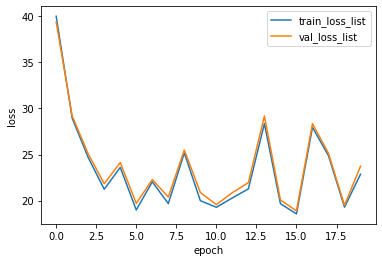

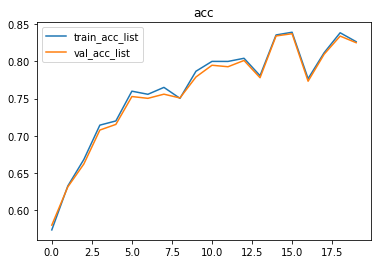

In [13]:
# 学習過程可視化
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train_loss_list')
plt.plot(val_loss_list, label='val_loss_list')
plt.legend()
plt.show()
# テストデータに適用
# test_loss = sess.run(loss_op, feed_dict={X: X_test, Y: y_test})
# print("test_mse : {:.3f}".format(test_loss))
plt.title('acc')
plt.plot(train_acc_list, label='train_acc_list')
plt.plot(val_acc_list, label='val_acc_list')
plt.legend()
plt.show()